# Fine-Tuning StableDiffusion XL with DreamBooth

Over the past few years Generative AI models have popped up everywhere - from creating realistic responses to complex questions, to generating images and music to impress art critics around the globe. In this notebook we use the Hugging Face [Stable Diffusion XL (SDXL)](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) model to create images from text prompts. You'll see how to import the SDXL model and use it to generate an image. 

From there, you'll see how you can fine-tune the model using [DreamBooth](https://huggingface.co/docs/diffusers/training/dreambooth), a method for easily fine-tuning a text-to-image model. We'll use a small number of photos of [Toy Jensen](https://blogs.nvidia.com/blog/2022/12/22/toy-jensen-jingle-bells/) in this notebook to fine-tune SDXL. This will allow us to generate new images that include Toy Jensen! 

After that, you'll have the chance to fine-tune the model on your own images. Perhaps you want to create an image of you at the bottom of the ocean, or in outer space? By the end of this notebook you will be able to! 

**IMPORTANT:** This project will utilize additional third-party open source software. Review the license terms of these open source projects before use. Third party components used as part of this project are subject to their separate legal notices or terms that accompany the components. You are responsible for confirming compliance with third-party component license terms and requirements.

### Stable Diffusion XL Model

First, we import the classes and libraries we need to run the notebook.

In [1]:
# Use this cell to directly run ONLY the from_pretrained and load previous saved LoRA weights
!pip install --upgrade pip
!pip install -q accelerate diffusers transformers peft torch
!pip install -q ipywidgets jupyterlab dataclass_wizard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2


In [2]:
import torch
from diffusers import StableDiffusionXLPipeline

# Necessary directory location variables
instance_data_dir = "../../data/toy-jensen"
output_dir = "../../models/tuned-toy-jensen/lora"   # pytorch_lora_weights.safetensors will be generated in this dir

Next, from the Hugging Face `diffusers` library, we create a `StableDiffusionXLPipeline` object from the SDXL base model. 

In [3]:
model_id="stabilityai/stable-diffusion-xl-base-1.0"

!echo ""
!echo "Using [{model_id}] as the pre-trained model for this demo"
!echo ""

pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16", use_safetensors=True)
pipe.to("cuda")


Using [stabilityai/stable-diffusion-xl-base-1.0] as the pre-trained model for this demo



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Fine-Tuning the model with DreamBooth

Fine-Tuning is used to train an existing Machine Learning Model, given new information. In our case, we want to teach the SDXL model about Toy Jensen. This will allow us to create the perfect image of Toy Jensen in Space!

[DreamBooth](https://arxiv.org/abs/2208.12242) provides a way to fine-tune a text-to-image model using only a few images. Let's use this to tune our SDXL Model so that it knows about Toy Jensen!

We have 8 photos of Toy Jensen in our dataset - let's take a look at one of them.

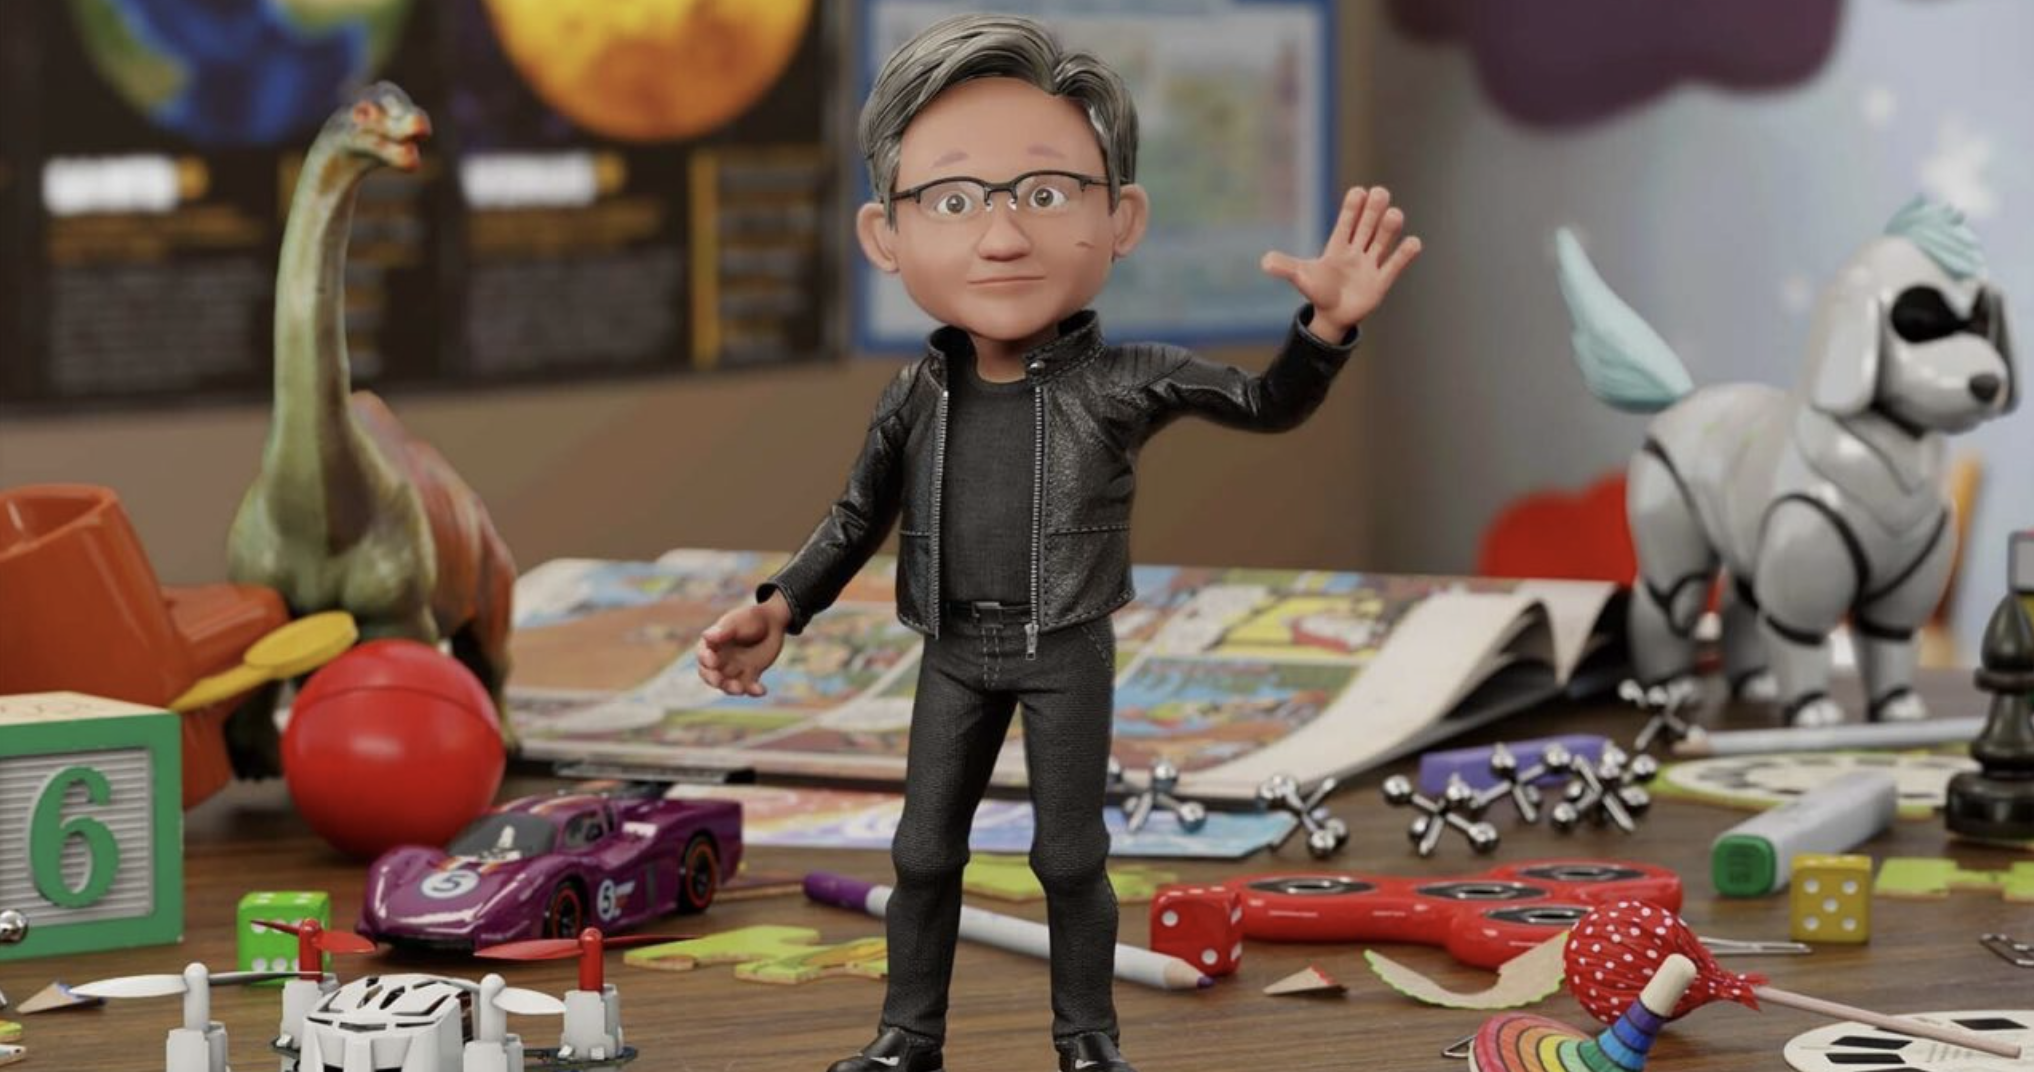

In [4]:
from IPython.display import Image

display(Image(filename=instance_data_dir + '/tj1.png'))

In [5]:
#Lets clone `diffusers` repo and use the correct versions of huggingface cli and torch
!rm -rf repos/diffusers
!mkdir -p repos

!git clone https://github.com/huggingface/diffusers repos/diffusers

!pip install -q accelerate

# Install diffusers from source as that's a requirement otherwise we'll get the following error:
#    **** This example requires a source install from HuggingFace diffusers ***
!pip install -q repos/diffusers

Cloning into 'repos/diffusers'...
remote: Enumerating objects: 72271, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 72271 (delta 206), reused 252 (delta 132), pack-reused 71889 (from 1)
Receiving objects: 100% (72271/72271), 50.90 MiB | 38.27 MiB/s, done.
Resolving deltas: 100% (53374/53374), done.


Now we can use Hugging Face and DreamBooth to fine-tune this model. To do this we create a config, then specify some flags like an instance prompt, a resolution and a number of training steps for the fine-tuning algorithm to run. 

In [6]:
from accelerate.utils import write_basic_config
write_basic_config()

Configuration already exists at /opt/app-root/src/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [7]:
import os
import torch

# Set PYTORCH_CUDA_ALLOC_CONF
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

# Print total memory and other device properties
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.get_device_properties(0))

23595909120
_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22502MB, multi_processor_count=80)


In [8]:
!echo ""
!echo "Using [{model_id}] as the pre-trained model for this demo"
!echo "  output dir for LoRA weights: [{output_dir}]"
!echo ""

torch.cuda.empty_cache()

!accelerate launch ./repos/diffusers/examples/dreambooth/train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path={model_id}  \
  --instance_data_dir={instance_data_dir} \
  --output_dir={output_dir} \
  --mixed_precision="bf16" \
  --instance_prompt="a photo of toy jensen" \
  --resolution=768 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=100 \
  --seed="0" \
  --resume_from_checkpoint=latest


Using [stabilityai/stable-diffusion-xl-base-1.0] as the pre-trained model for this demo
  output dir for LoRA weights: [../../models/tuned-toy-jensen/lora]

10/16/2024 14:55:52 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'thresholding', 'rescale_betas_zero_snr', 'dynamic_thresholding_ratio', 'variance_type', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'latents_mean', 'shift_factor', 'latents_std', 'use_post_quant_conv', 'mid_block_add_attention', 'use_quant_conv'} was not found in config. Values will be initialized to default va

In [9]:
# Uncomment next 1 statement if re-running steps from this cell (in case of OOM and Kernel disconnect)
# output_dir = "../../models/tuned-toy-jensen/lora"

!echo
!echo "Data in model output dir [{output_dir}]"
!ls -lh {output_dir}


Data in model output dir [../../models/tuned-toy-jensen/lora]
total 23M
drwxrwsr-x. 3 1000990000 1000990000 4.0K Oct 10 15:32 logs
-rw-rw-r--. 1 1000990000 1000990000  23M Oct 16 15:01 pytorch_lora_weights.safetensors


Now that the model is fine-tuned, let's tell our notebook where to find it.

In [28]:
# Uncomment next 2 statements if re-running steps from this cell (in case of OOM and Kernel disconnect)
# model_id="stabilityai/stable-diffusion-xl-base-1.0"
# output_dir = "../../models/tuned-toy-jensen/lora"   # pytorch_lora_weights.safetensors will be generated in this dir

# Load the model again and also load the LoRA weights that were generated earlier (this for fine-tuning the model)
pipe = StableDiffusionXLPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.load_lora_weights(output_dir)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Finally, we can use our fine-tuned model to create an image with Toy Jensen in it. Let's give it a go! 

  0%|          | 0/75 [00:00<?, ?it/s]

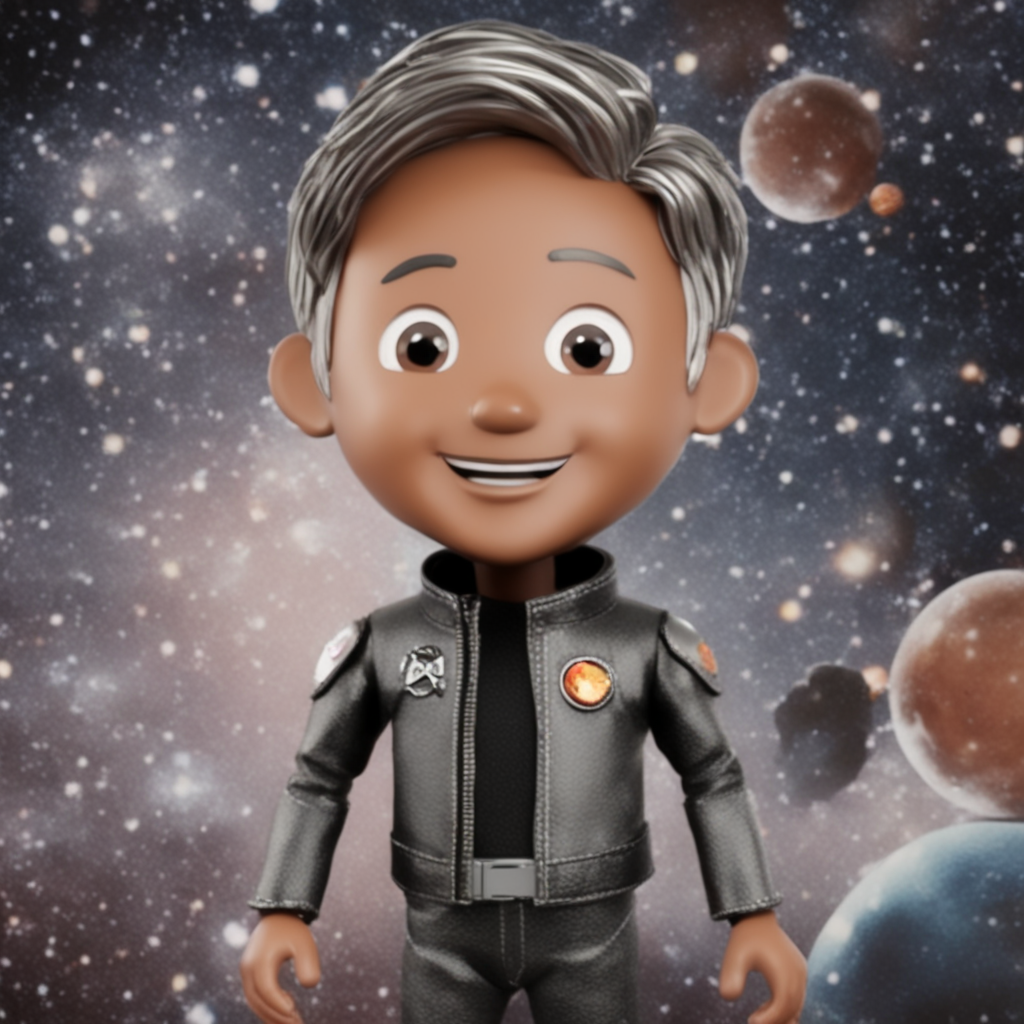

In [29]:
image = pipe("A picture of toy jensen in space", num_inference_steps=75).images[0]

image

Wow - look at him go! 

In [12]:
# -------------------------------------------------
# Import the transfer notebook to upload our pytorch model to minio
# -------------------------------------------------
%run ./Xfer-to-minio.ipynb

# Uncomment next statement if running only this cell (in case of OOM and Kernel disconnect)
# output_dir = "../../models/tuned-toy-jensen/lora"
prefix = "model/lora"
s3_env: S3Env = init_env()
minio_client: Minio = init_minio(s3_env)

dir_model = MinioBucketMeta(model_data_dir=output_dir,
                            bucket_name=s3_env.bucket_name,
                            client=minio_client,
                            prefix=prefix,
                            exclude_dirs_set=['logs'])
upload_files(dir_model)

Uploading files from [../../models/tuned-toy-jensen/lora] directory...
 -->> Created bucket [nvidia-model]
root=../../models/tuned-toy-jensen/lora, dirs=['logs'], files=['pytorch_lora_weights.safetensors']
Ignored ['logs'] directories...
   -> Trying to upload file [../../models/tuned-toy-jensen/lora/pytorch_lora_weights.safetensors] with key [model/lora/pytorch_lora_weights.safetensors] to the bucket [nvidia-model]... SUCCESS
